In [1]:
import os
import pyomo.environ as pyo
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx
import pickle
from matplotlib import ticker

import sys

sys.path.append("../../src")

import stochastic_benchmark as SB
import bootstrap
import interpolate
import stats
from utils_ws import *

## Simulated Annealing (SA)

SA is an optimization algorithm that works by navigating the input space and evaluating the objective function (energy) similarly to hill climbing. The main difference is that SA implements a strategy to avoid getting stuck in local optima.

The general idea is to allow moves to a worse position, but in a structured way. When a candidate solution is selected, the probability of actually moving to the new position is determined by the change in the objective function and by a metric called **temperature**. When the temperature is high, the chance of performing a jump to a worse state increases, and the opposite happens when the temperature is low. By continuously decreasing the temperature during the execution of the algorithm, it can escape local optima during the first stages (high temperature), but it settles into a position towards the end of the execution (low temperature).

### Probability of Making a Jump

**Case 1:**
$$
\Delta E = E_{current} - E_{next} > 0
$$

It is always advantageous to move to a state with a better objective function. In this case, the probability is $P = 1$.

**Case 2:**
$$
\Delta E = E_{current} - E_{next} < 0
$$

In this case, the probability of taking the step is determined by:

$$
P = e^{-|\Delta E| / T}
$$

**Note:** This formulation applies to a minimization problem. To solve a maximization problem, the only change is that $\Delta E = E_{next} - E_{current}$.

### Temperature Decrease

The way the temperature decreases during the algorithm's execution varies between implementations. This is referred to as the temperature **schedule**, which is a function of time or the number of iterations.

**Note:** $\beta = 1 / T$ is also commonly used in the implementation of the algorithm.

Let's define a larger model, with 100 variables and random weights.

Assume that we are interested at the instance created with random weights $h_{i}, J_{i, j} \sim U[-1, +1]$.

### Problem statement

We pose the Ising problem as the following optimization problem:

$$
\min_{s \in \{ \pm 1 \}^n} H(s) = \min_{s \in \{ \pm 1 \}^n} \sum_{(i, j) \in E(G)} J_{i,j}s_is_j + \sum_{i \in V(G)} h_is_i + \beta
$$

where we optimize over spins $s \in \{ \pm 1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{i,j}$ and the linear coefficients are $h_i$.
We also include an arbitrary offset of the Ising model $\beta$. This ising model can be considered a Sherrington-Kirkpatrick (SK) model, being, therefore, fully connected.

### Loading The Data

The following cells load data from Simulated Annealing runs performed on 20 different problem instances. At each sweep step, 1000 reads were made.

These runs were originally executed using the [QuboNotebooks Repository](https://github.com/JuliaQUBO/QUBONotebooks/blob/main/notebooks_py/5-Benchmarking_python.ipynb).

In [4]:
current_path = os.getcwd()
pickle_path = os.path.join(current_path, 'results/')
if not(os.path.exists(pickle_path)):
    print('Results directory ' + pickle_path +
          ' does not exist. We will create it.')
    os.makedirs(pickle_path)
    !wget -O {pickle_path}results.zip -N -q "https://github.com/JuliaQUBO/QUBONotebooks/raw/main/notebooks_py/results.zip"

In [6]:
import zipfile
zip_name = os.path.join(pickle_path, 'results.zip')
overwrite_pickles = False
if os.path.exists(zip_name):
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(pickle_path)
    print('Results zip file has been extrated to ' + pickle_path)

Results zip file has been extrated to /home/jvpcms/purdue-internship/stochastic-benchmark-jvpcms/examples/Simulated_Annealing/results/


### Bootstrapping

We are interested in comparing the execution of the algorithm as the schedule step (number of sweeps) varies for different numbers of reads. However, the raw data we have only contains runs with 1000 reads at each schedule step. Bootstrapping can show us what the data was expected to look like had we performed SA with, say, 1, 10, and 100 reads at each sweep.

**Note:** The original data and the bootstrapped data vary in one key aspect. From the original data, we are able to draw absolute values like the minimum and average of the energy reads (1000 in our case). However, the bootstrapping process will give us distributions for these metrics, meaning the "minimum" and "average" energy values for the other numbers of reads are not absolute. Rather, they are expected values according to a distribution and have associated confidence intervals.

In the next cells, we will:
- Load the full raw data for each instance (the 1000 energy reads at each sweep);
- Compute the performance ratio using the SB framework;
- Perform Bootstrapping to infer information about the performance ratio for different numbers of reads.

In [ ]:
from itertools import chain

def load_raw_data(instance_id, schedule) -> pd.DataFrame:
    
    sweeps = list(chain(range(1, 250, 1), range(250, 1001, 10)))
    header_names = [
        'instance', 
        'sweeps', 
        'energy',
        'resource'
    ]

    raw_data_df = pd.DataFrame(columns=header_names)

    for sweep in sweeps:
        filename = f'raw_runs/{instance_id}_{schedule}_{sweep}.p'
        if not os.path.exists(filename):
            return None
    
        with open(filename, 'rb') as f:
            samples = pickle.load(f)
        
        energy_reads_at_sweep = np.array(samples.data_vectors['energy'])

        for energy in energy_reads_at_sweep:
            raw_data_df.loc[len(raw_data_df)] = [instance_id, sweep, energy, 1]

    return raw_data_df


Convert results to the format expected by the Stochast Benchmark Framework

In [32]:
schedule = 'geometric'
override_saved_data = False

# First check if compressed data exists
results_path = os.path.join(current_path, 'results/')
compressed_data_path = os.path.join(results_path, 'granular_data.zip')
if os.path.exists(compressed_data_path):
    print("Compressed data exists. Unzipping...")
    with zipfile.ZipFile(compressed_data_path, 'r') as zip_ref:
        zip_ref.extractall(current_path)
else:
    # If compressed data does not exist, we need to compile the granular data
    granular_data_path = os.path.join(current_path, 'granular_data/')
    if not os.path.exists(granular_data_path):
        os.makedirs(granular_data_path)

    for instance_id in range(20):

        print(f"Compiling data for instance {instance_id}")

        filename = os.path.join(granular_data_path, f'granular_data_{instance_id}.pkl')
        if os.path.exists(filename) and not override_saved_data:
            print(f"Data for instance {instance_id} already exists. Skipping...")
            continue

        raw_data_df = load_raw_data(instance_id, schedule)
        pickle.dump(raw_data_df, open(filename, 'wb'))
        print(f"Data for instance {instance_id} saved to {filename}")
        

    # zip the granular data entire directory
    with zipfile.ZipFile(compressed_data_path, 'w') as zip_ref:
        for root, dirs, files in os.walk(granular_data_path):
            for file in files:
                file_path = os.path.join(root, file)
                # Create archive path relative to granular_data_path
                arcname = os.path.relpath(file_path, granular_data_path)
                zip_ref.write(file_path, arcname=os.path.join('granular_data', arcname))

Compressed data exists. Unzipping...


In [33]:
def load_granular_data(instance_id) -> pd.DataFrame:
    granular_data_path = os.path.join(current_path, 'granular_data/')
    filename = os.path.join(granular_data_path, f'granular_data_{instance_id}.pkl')
    return pickle.load(open(filename, 'rb'))

In [34]:
results_name = "all_results.pkl"
results_name = os.path.join(pickle_path, results_name)

results = pickle.load(open(results_name, "rb"))

def get_shared_args(instance_id):
  default_reads = 1000
  default_confidence_level = 68
  shared_args_for_perf_ratio = {
      "response_col": "energy",
      "resource_col": "resource", # the resource is not used at this step, just for compatibility
      "random_value": results[instance_id]['random_energy'][schedule][default_reads],
      "best_value": results[instance_id]['min_energy'][schedule][default_reads],
      "confidence_level": default_confidence_level
  }
  return shared_args_for_perf_ratio

### Performance Metric

We are interested in the "performance ratio" metric. In this particular problem, it is calculated as follows:

- First, we sample a subset from the input space and calculate the associated energies. Specifically, we use 1000 random bitstrings in this case.
- The best (minimum) energy found across the random sample is denoted as `minimum`, while the mean energy across the random sampling is denoted as `random`.
- The approximation ratio is calculated across an increasing number of sweeps of simulated annealing, where `found` is the best energy found at the current moment in the algorithm's execution.

$$
performance\space ratio = \frac{found - random}{minimum - random}
$$

Even though it is (very) unlikely that we found the best solution during the random sampling, this metric is useful because it gives us a general idea of how good our currently found solution is.

More details are available at the [QuboNotebooks Repository](https://github.com/JuliaQUBO/QUBONotebooks/blob/main/notebooks_py/5-Benchmarking_python.ipynb).

This step **performs Bootstrapping** on the various resample sizes and **computes the Performance Ratio** simultaneously.

In [35]:
import bootstrap
import success_metrics

checkpoints_path = "checkpoints"
override_bootstrap = False

if not os.path.exists(checkpoints_path):
    os.makedirs(checkpoints_path)

for instance_id in range(20):
  file_path = os.path.join(checkpoints_path, f"bootstrapped_results_inst={instance_id}.pkl")
  if os.path.exists(file_path) and not override_bootstrap:
    continue

  shared_args_for_perf_ratio = get_shared_args(instance_id)

  metric_args = {
    "Response": {"opt_sense": -1}
  }

  def update_rule(bs_params, df):
      return None

  bsParams = bootstrap.BootstrapParameters(
      shared_args=shared_args_for_perf_ratio,
      metric_args=metric_args,
      success_metrics=[success_metrics.Response, success_metrics.PerfRatio],
      bootstrap_iterations=1000,
      update_rule=update_rule
  )

  boots_range = [1, 10, 100, 1000]
  bsParams_iter = bootstrap.BSParams_range_iter()(bsParams, boots_range)

  granular_data_df = load_granular_data(instance_id)
  bs_df = bootstrap.Bootstrap(
    granular_data_df,
    group_on=["instance", "sweeps"],
    bs_params_list=bsParams_iter
  )

  # Add a column for the number of reads identical to boots column
  bs_df["reads"] = bs_df["boots"]

  # save bs_df as pickle
  pickle.dump(bs_df, open(file_path, "wb"))

 98%|█████████▊| 319/325 [00:02<00:00, 113.34it/s]/home/jvpcms/purdue-internship/stochastic-benchmark-jvpcms/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
 90%|████████▉ | 292/325 [00:02<00:00, 100.56it/s]/home/jvpcms/purdue-internship/stochastic-benchmark-jvpcms/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping colu

In [38]:
here = os.getcwd()
parameter_names = [
    "sweeps",
    "reads"
]  # think about whether iterations should be a parameter or not.
instance_cols = [
    "instance"
]  # indicates how instances should be grouped, default is ['instance']

## Response information
response_key = "PerfRatio"  # Column with the response
response_dir = 1  # whether we want to maximize (1) or minimize (-1), default is 1

## Optimizations informations
recover = True  # Whether we want to read dataframes when available, default is True
reduce_mem = True  # Whether we want to segment bootstrapping and interpolation to reduce memory usage, default is True
smooth = True  # Whether virtual best should be monontonized, default is True

sb = SB.stochastic_benchmark(
    parameter_names=parameter_names,
    here=here,
    instance_cols=instance_cols,
    response_key=response_key,
    response_dir=response_dir,
    smooth=smooth,
)

### Resource

In this analysis, we examine how the approximation ratio evolves as the number of sweeps and reads increases during algorithm execution.

The number of sweeps times the number of reads serves as our resource metric. This corresponds to the total time spent in a SA run. The objective is to achieve a high approximation ratio while minimizing that product (i.e., using fewer computational resources).

In [39]:
# Load Bootstrap data.
# The data is already boostrapped, but needs to be loaded into memory

shared_args = {
    "response_col": "PerfRatio",
    "resource_col": "resource",
    "response_dir": 1,
    "confidence_level": 68,
}
boots_range = [1, 10, 100, 1000]
bsParams = bootstrap.BootstrapParameters(
    shared_args=shared_args, update_rule=lambda df: None
)
bs_iter_class = bootstrap.BSParams_range_iter()
bsParams_iter = bs_iter_class(bsParams, boots_range)
sb.run_Bootstrap(bsParams_iter)

In [40]:
# Interpolate
def resource_fcn(df):
    return df["reads"] * df["sweeps"]


iParams = interpolate.InterpolationParameters(resource_fcn, parameters=parameter_names)
sb.run_Interpolate(iParams)

  0%|          | 0/1300 [00:00<?, ?it/s]

100%|██████████| 1300/1300 [00:02<00:00, 495.51it/s]


### Initial Investigation

For instance 0 of the problem, let's investigate where the performance ratio reaches the extreme values, 0 and 1, across the various numbers of sweeps.

In [41]:
def filter_df_by_reads(df, reads):
    return df[df["reads"] == reads]

In [42]:
def find_sweep_with_min_perf_ratio(df) -> tuple[int, float]:
    min_perf_ratio = df["Key=PerfRatio"].min()
    return df[df["Key=PerfRatio"] == min_perf_ratio]["sweeps"].values[0], min_perf_ratio

def find_sweep_with_max_perf_ratio(df) -> tuple[int, float]:
    max_perf_ratio = df["Key=PerfRatio"].max()
    return df[df["Key=PerfRatio"] == max_perf_ratio]["sweeps"].values[0], max_perf_ratio

In [43]:
bootstrapped_data_path = os.path.join(checkpoints_path, f'bootstrapped_results_inst=0.pkl')
bootstrapped_data = pickle.load(open(bootstrapped_data_path, 'rb'))

print(f"{'Reads':<20}|{'Min Perf Ratio':<20}|{'At':<20}|{'Max Perf Ratio':<20}|{'At':<20}")
print("-"*20 + "|" + "-"*20 + "|" + "-"*20 + "|" + "-"*20 + "|" + "-"*20)

df_1000 = filter_df_by_reads(bootstrapped_data, 1000)
min_perf_ratio_sweep, min_perf_ratio = find_sweep_with_min_perf_ratio(df_1000)
max_perf_ratio_sweep, max_perf_ratio = find_sweep_with_max_perf_ratio(df_1000)
print(f"{1000:<20}|{min_perf_ratio:<20}|{min_perf_ratio_sweep:<20}|{max_perf_ratio:<20}|{max_perf_ratio_sweep:<20}")
print("-"*20 + "|" + "-"*20 + "|" + "-"*20 + "|" + "-"*20 + "|" + "-"*20)

df_100 = filter_df_by_reads(bootstrapped_data, 100)
min_perf_ratio_sweep, min_perf_ratio = find_sweep_with_min_perf_ratio(df_100)
max_perf_ratio_sweep, max_perf_ratio = find_sweep_with_max_perf_ratio(df_100)
print(f"{100:<20}|{min_perf_ratio:<20}|{min_perf_ratio_sweep:<20}|{max_perf_ratio:<20}|{max_perf_ratio_sweep:<20}")
print("-"*20 + "|" + "-"*20 + "|" + "-"*20 + "|" + "-"*20 + "|" + "-"*20)

df_10 = filter_df_by_reads(bootstrapped_data, 10)
min_perf_ratio_sweep, min_perf_ratio = find_sweep_with_min_perf_ratio(df_10)
max_perf_ratio_sweep, max_perf_ratio = find_sweep_with_max_perf_ratio(df_10)
print(f"{10:<20}|{min_perf_ratio:<20}|{min_perf_ratio_sweep:<20}|{max_perf_ratio:<20}|{max_perf_ratio_sweep:<20}")
print("-"*20 + "|" + "-"*20 + "|" + "-"*20 + "|" + "-"*20 + "|" + "-"*20)

df_1 = filter_df_by_reads(bootstrapped_data, 1)
min_perf_ratio_sweep, min_perf_ratio = find_sweep_with_min_perf_ratio(df_1)
max_perf_ratio_sweep, max_perf_ratio = find_sweep_with_max_perf_ratio(df_1)
print(f"{1:<20}|{min_perf_ratio:<20}|{min_perf_ratio_sweep:<20}|{max_perf_ratio:<20}|{max_perf_ratio_sweep:<20}")
print("-"*20 + "|" + "-"*20 + "|" + "-"*20 + "|" + "-"*20 + "|" + "-"*20)

Reads               |Min Perf Ratio      |At                  |Max Perf Ratio      |At                  
--------------------|--------------------|--------------------|--------------------|--------------------
1000                |0.8397197927530982  |1.0                 |1.0                 |22.0                
--------------------|--------------------|--------------------|--------------------|--------------------
100                 |0.8046064604028247  |1.0                 |1.0                 |107.0               
--------------------|--------------------|--------------------|--------------------|--------------------
10                  |0.7493715732969289  |1.0                 |0.9999575386386068  |820.0               
--------------------|--------------------|--------------------|--------------------|--------------------
1                   |0.6616491600405551  |1.0                 |0.9802089467956904  |1000.0              
--------------------|--------------------|-------------

This first analysis indicates that choosing a large number of reads is a good strategy given a certain amount of finite resource. However, this still doesn't paint the entire picture.

- How to "distribute" the parameters given the resources?
- How close to the virtual best does a certain amount of available resources get us?

These questions will be answered by the complete framework evaluation.

In [44]:
# Set up Stats computations
train_test_split = 0.8
metrics = ["PerfRatio"]
stParams = stats.StatsParameters(metrics=metrics, stats_measures=[stats.Median()])
sb.run_Stats(stParams, train_test_split)

100%|██████████| 654/654 [00:00<00:00, 1619.83it/s]


In [45]:
sb.run_baseline()

In [46]:
sb.run_ProjectionExperiment("TrainingStats", None, None)
sb.run_ProjectionExperiment("TrainingResults", None, None)

In [47]:
import plotting

plotting.monotone = True
sb.initPlotting()

100%|██████████| 100/100 [00:00<00:00, 1386.19it/s]


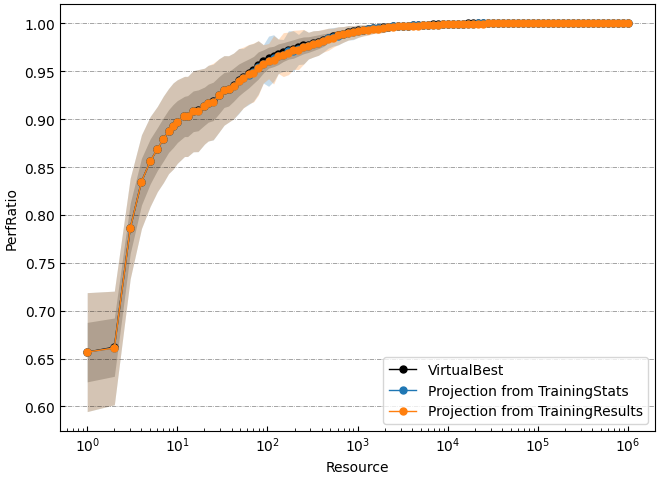

In [48]:
fig, axs = sb.plots.plot_performance()
fig.savefig("performance.png")

100%|██████████| 100/100 [00:00<00:00, 1829.43it/s]


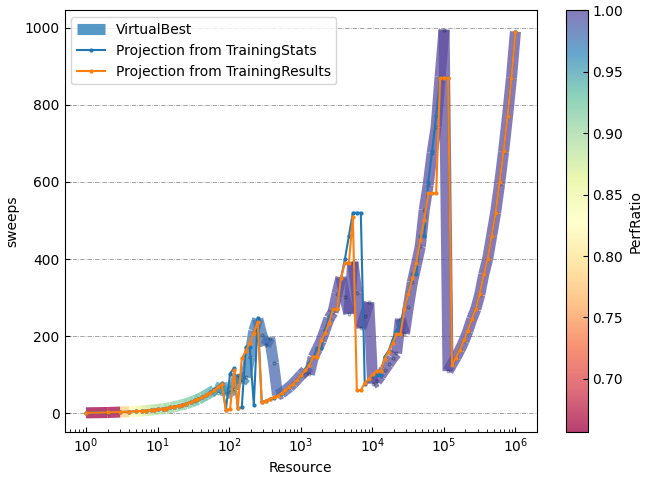

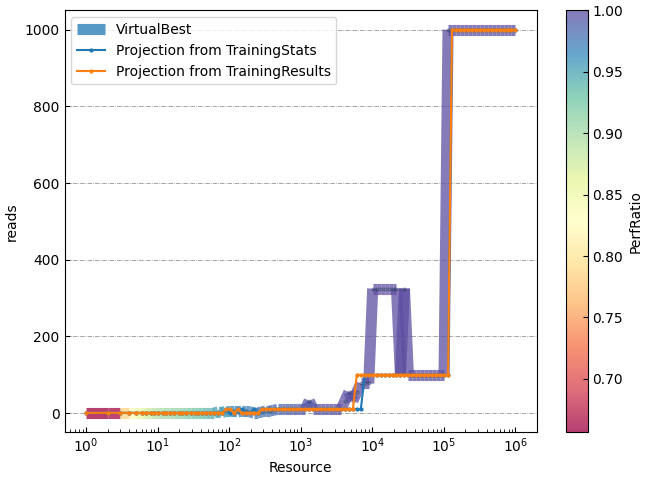

In [49]:
figs, axes = sb.plots.plot_parameters_separate()
for param, fig in figs.items():
    fig.savefig(param + ".png")

### Conclusion

As mentioned before, the initial analysis does not paint the whole picture. From that high-level evaluation, we saw that 1,000 reads per sweep gives us a good approximation ratio at a low number of sweeps (22). This corresponds to a 22,000 value for our resource. However, looking at the input recommendation plots, we see that:

- The only moment when it is worth using 1,000 reads is when we have more than $10^5$ available resources.
- We can reach 1.0 performance ratio around a much lower resource value ($10^3$).
- From the first plot, it is noticeable that the confidence interval becomes narrower from resource value $10^3$ and forward.

From the deeper analysis provided by the framework, we can see that there is pretty much no point in ever using 1,000 or even 100 reads per sweep. We should, instead, stick with 1 or 10 reads per sweep, investing, at most, $10^3$ resources.